<a href="https://colab.research.google.com/github/Ariarti/App/blob/master/household_obj_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
%load_ext tensorboard

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os, shutil 
import zipfile

In [ ]:
cd /content/drive/My Drive/06.06

/content/drive/My Drive/06.06


In [ ]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/My Drive/06.06/household_objects.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
base_dir = '/content/drive/My Drive/16.05/household_objects'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

train_glass_dir = os.path.join(train_dir, 'cup')
train_knife_dir = os.path.join(train_dir, 'knife')


validation_glass_dir = os.path.join(validation_dir, 'cup')
validation_knife_dir = os.path.join(validation_dir, 'knife')


test_glass_dir = os.path.join(test_dir, 'cup')
test_knife_dir = os.path.join(test_dir, 'knife')


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
rescale=1./255,
rotation_range=40,
width_shift_range=0.2,
height_shift_range=0.2,
shear_range=0.2,
zoom_range=0.1,
horizontal_flip=True,)

In [ ]:
train_generator = train_datagen.flow_from_directory(
train_dir,
target_size=(71, 71),
batch_size=40,
class_mode='categorical')

Found 5638 images belonging to 2 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory(
validation_dir,
target_size=(71, 71),
batch_size=5,
class_mode='categorical')

Found 200 images belonging to 3 classes.


In [ ]:
for data_batch, labels_batch in train_generator:
  print('data batch shape:', data_batch.shape)
  print('labels batch shape:', labels_batch.shape)
  break

data batch shape: (40, 71, 71, 3)
labels batch shape: (40, 2)


In [ ]:
classes = ['glass', 'knife', 'saucepan', 'spoon']

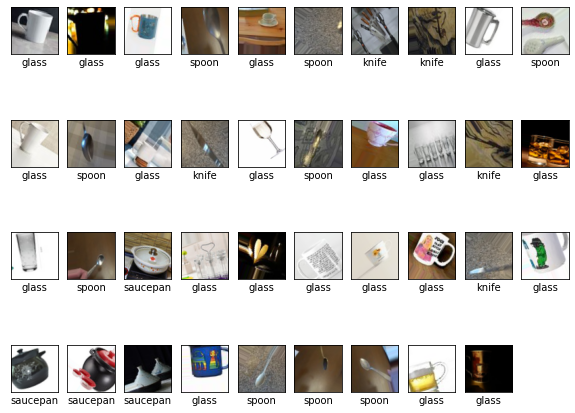

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,10))
for i in range(1, 40):
  plt.subplot(5,10,i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(data_batch[i], cmap=plt.cm.binary)
  plt.xlabel(classes[np.argmax(labels_batch[i])])

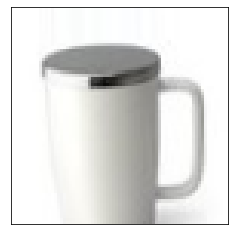

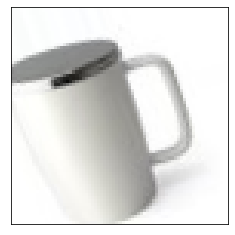

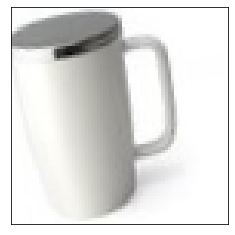

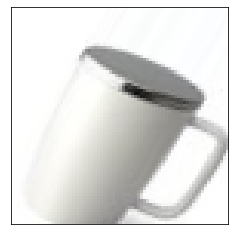

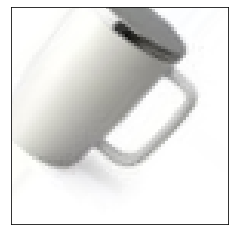

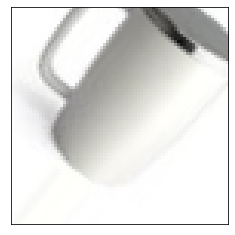

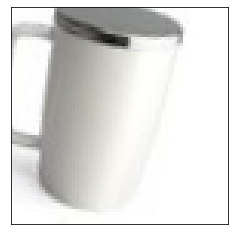

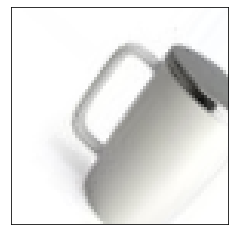

In [ ]:
from tensorflow.keras.preprocessing import image
fnames = [os.path.join(train_cup_dir, fname) for
fname in os.listdir(train_cup_dir)]
img_path = fnames[2]
img = image.load_img(img_path, target_size=(71, 71))
x = image.img_to_array(img)
x = x.reshape((1,) + x.shape)
i = 0
for batch in train_datagen.flow(x, batch_size=1):
  plt.figure(i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  imgplot = plt.imshow(image.array_to_img(batch[0]))
  i += 1
  if i % 8 == 0:
    break

plt.show()

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras import optimizers

In [ ]:
input_tensor = Input(shape=(71, 71, 3))
x = layers.SeparableConv2D(64, (3,3), padding="same", activation='relu')(input_tensor)
x = layers.BatchNormalization()(x)
x = layers.AveragePooling2D(2)(x)
x = layers.SeparableConv2D(128, (3,3), padding="same", activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.SeparableConv2D(256, (3,3), padding="same", activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(4, activation='softmax')(x)
model = Model(input_tensor, output_tensor)
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 71, 71, 3)]       0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 71, 71, 64)        283       
_________________________________________________________________
batch_normalization_1 (Batch (None, 71, 71, 64)        256       
_________________________________________________________________
average_pooling2d_1 (Average (None, 35, 35, 64)        0         
_________________________________________________________________
separable_conv2d_4 (Separabl (None, 35, 35, 128)       8896      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
separable_conv2d_5 (Separabl (None, 17, 17, 256)       3417

In [ ]:
import tensorflow.keras

callbacks_list = [
tensorflow.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
patience=10,
),                  
tensorflow.keras.callbacks.ModelCheckpoint(
filepath='household_V1.h5',
monitor='val_loss',
save_best_only=True,
),
tensorflow.keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.1,
patience=10,
)
]

In [ ]:
callbacks_list = [
tensorflow.keras.callbacks.EarlyStopping(
monitor='val_accuracy',
patience=10,
),                  
tensorflow.keras.callbacks.ModelCheckpoint(
filepath='household_V1.h5',
monitor='val_loss',
save_best_only=True,
)
]

In [ ]:
model.compile(optimizer = optimizers.RMSprop(),
loss='categorical_crossentropy',
metrics=['accuracy'])

history = model.fit_generator(
train_generator,
steps_per_epoch=292,
epochs=100,
callbacks=callbacks_list,
validation_data=validation_generator,
validation_steps=80,
)

Epoch 1/100
292/292 [==============================] - 36s 122ms/step - loss: 0.9169 - accuracy: 0.6064 - val_loss: 1.2599 - val_accuracy: 0.4425 - lr: 0.0010
Epoch 2/100
292/292 [==============================] - 39s 134ms/step - loss: 0.8094 - accuracy: 0.6460 - val_loss: 0.8037 - val_accuracy: 0.7750 - lr: 0.0010
Epoch 3/100
292/292 [==============================] - 38s 131ms/step - loss: 0.7489 - accuracy: 0.6765 - val_loss: 0.7270 - val_accuracy: 0.5850 - lr: 0.0010
Epoch 4/100
292/292 [==============================] - 38s 130ms/step - loss: 0.7069 - accuracy: 0.7033 - val_loss: 0.6258 - val_accuracy: 0.7525 - lr: 0.0010
Epoch 5/100
292/292 [==============================] - 35s 121ms/step - loss: 0.6648 - accuracy: 0.7187 - val_loss: 0.6583 - val_accuracy: 0.7300 - lr: 0.0010
Epoch 6/100
292/292 [==============================] - 38s 131ms/step - loss: 0.6388 - accuracy: 0.7300 - val_loss: 0.5980 - val_accuracy: 0.7325 - lr: 0.0010
Epoch 7/100
292/292 [=========================

In [ ]:
model.save('my_model.h5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/My Drive/12Мая/household_DenseNet201_do.h5')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 71, 71, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 77, 77, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 36, 36, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 36, 36, 64)   256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
hard_dir = '/content/drive/My Drive/8May'

In [ ]:
hard_test_dir = os.path.join(hard_dir, 'test')


In [ ]:
hard_test_generator = test_datagen.flow_from_directory(
hard_test_dir,
target_size=(71, 71),
batch_size=20,
class_mode='categorical')

Found 400 images belonging to 4 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
test_dir,
target_size=(71, 71),
batch_size=40,
class_mode='categorical')

Found 800 images belonging to 4 classes.


In [ ]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=20)
print('test acc:', test_acc)
test_loss, test_acc = model.evaluate_generator(hard_test_generator, steps=20)
print('test acc:', test_acc)

test acc: 0.8349999785423279
test acc: 0.38999998569488525


In [ ]:
layer_names = []
for layer in model.layers[1:8]:
  layer_names.append(layer.name)
layer_names

['separable_conv2d_12',
 'max_pooling2d_10',
 'separable_conv2d_13',
 'batch_normalization_4',
 'max_pooling2d_11',
 'separable_conv2d_14',
 'max_pooling2d_12']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


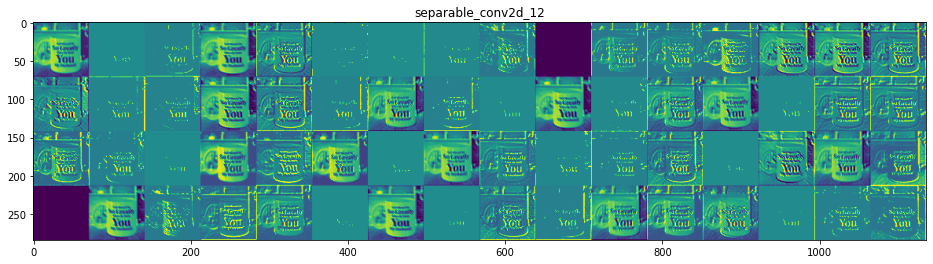

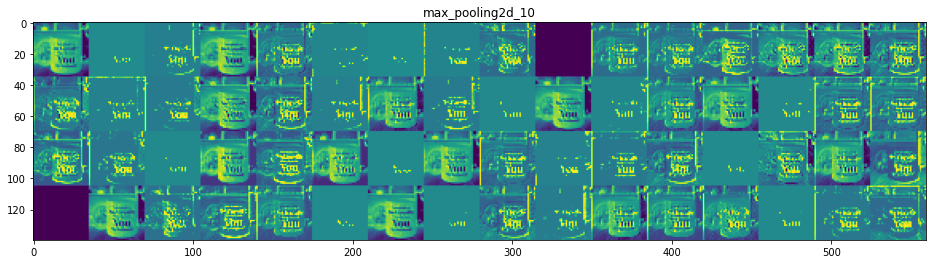

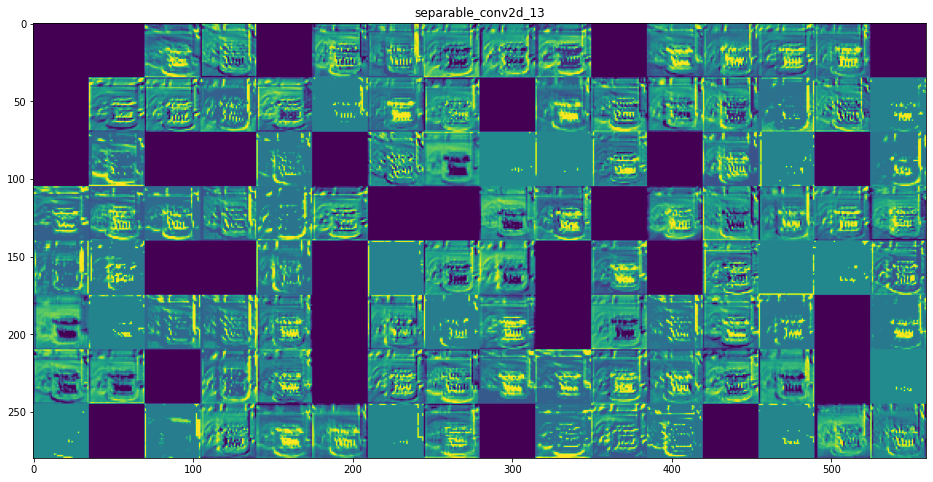

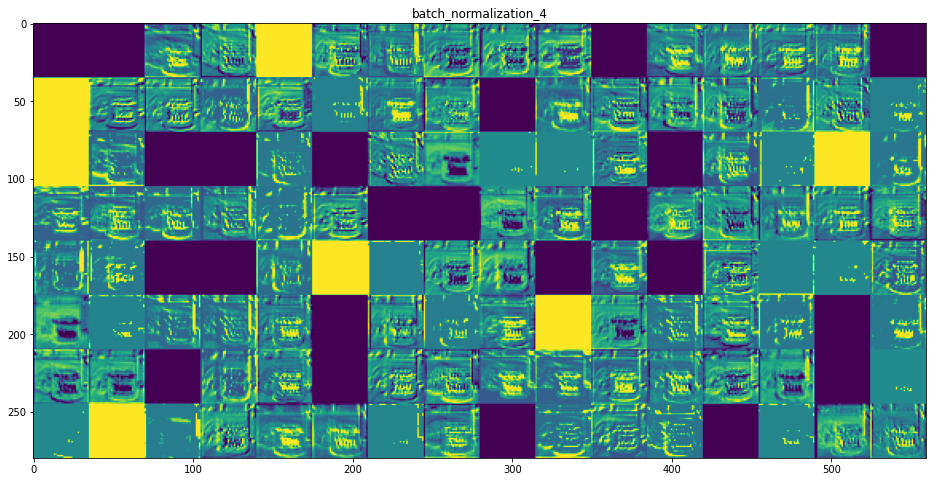

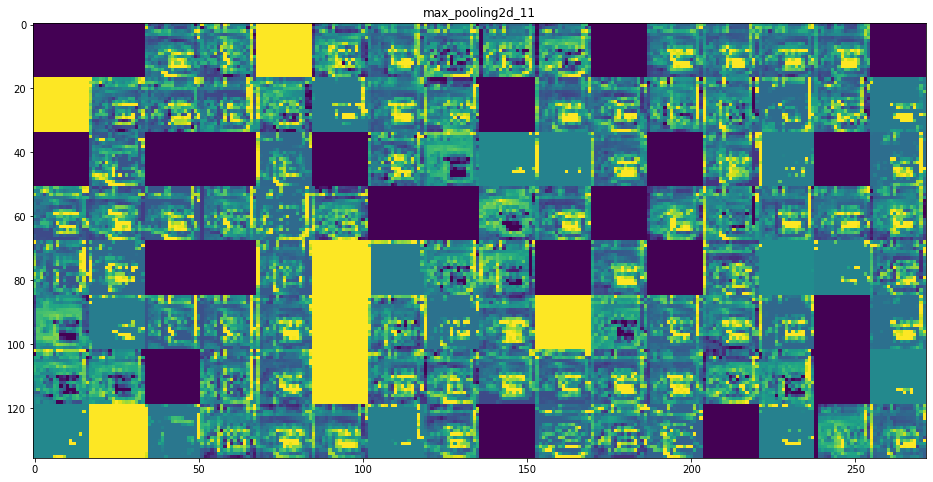

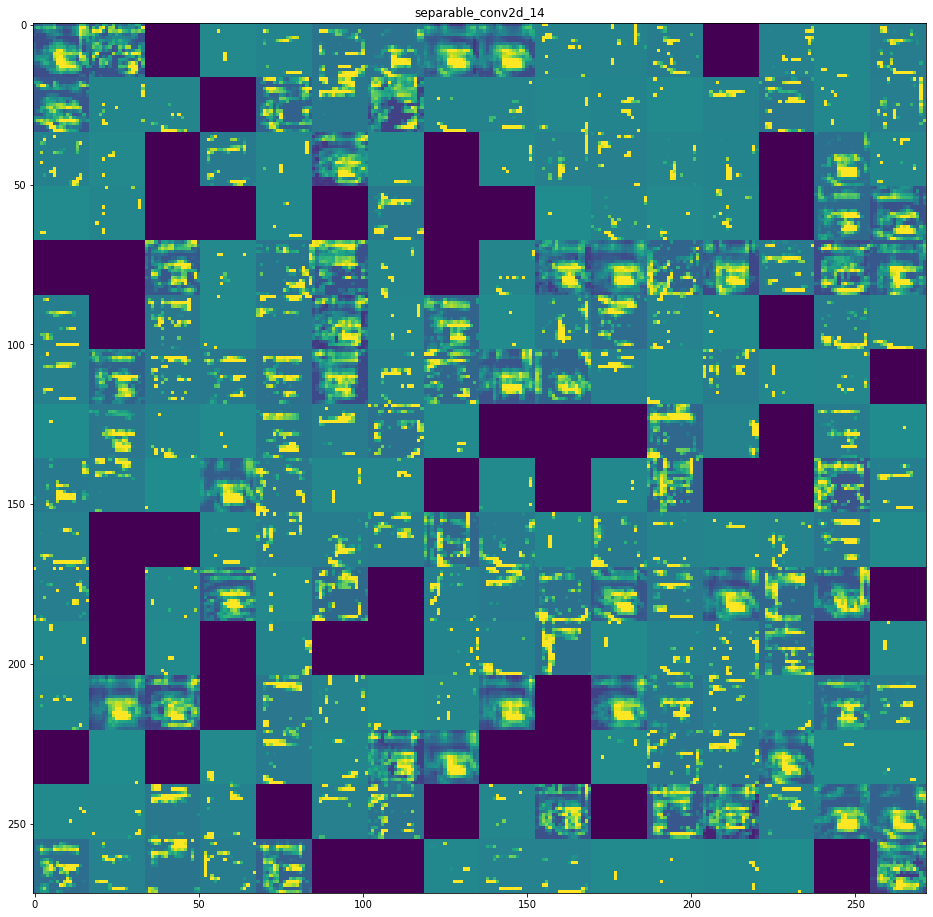

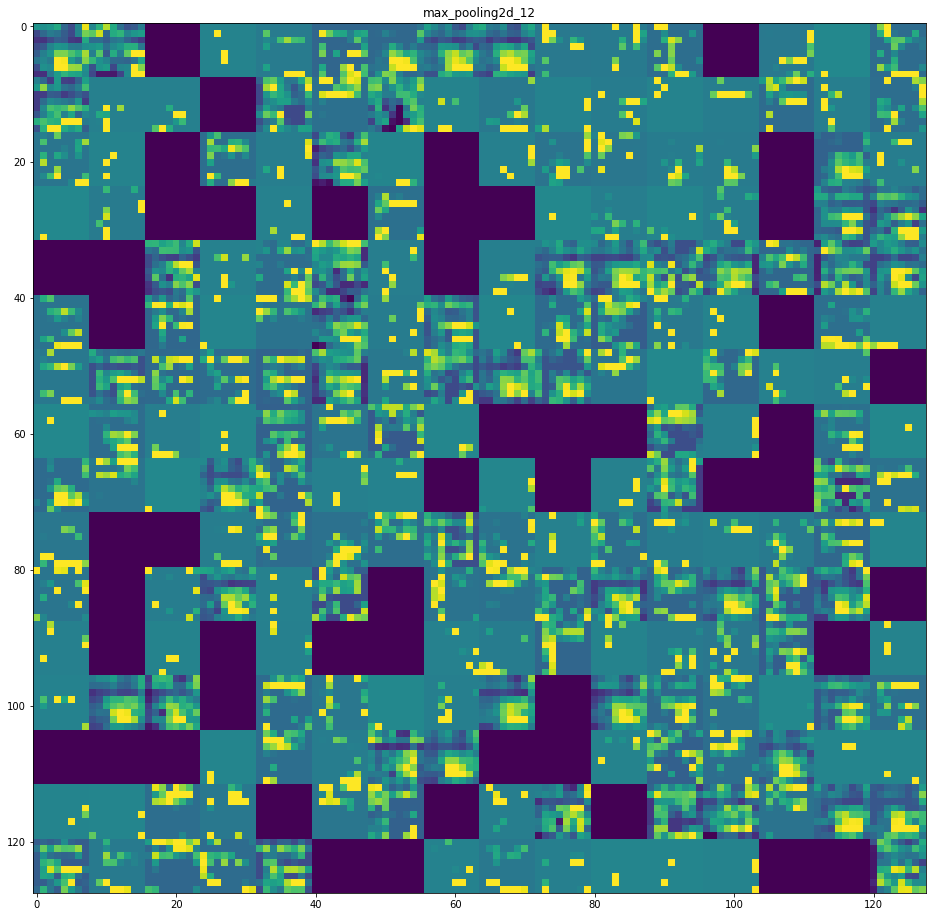

In [ ]:
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0, :, :, col * images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image += 128
      channel_image = np.clip(channel_image, 0, 255).astype('uint8')
      display_grid[col * size : (col + 1) * size,
        row * size : (row + 1) * size] = channel_image
  scale = 1. / size
  plt.figure(figsize=(scale * display_grid.shape[1],
                      scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
from datetime import datetime
import time

In [ ]:
arr = [0.056828, 0.043421, 0.050377, 0.054378, 0.045984]

In [ ]:
print( sum(arr)/len(arr) )

0.050197599999999995


In [ ]:

preds = model.predict(img_tensor)


In [ ]:
preds

array([[0.93386775, 0.05951536, 0.00474543, 0.0018714 ]], dtype=float32)

In [ ]:
classes

['glass', 'knife', 'saucepan', 'spoon']

In [ ]:
classes[np.argmax(preds)]

'saucepan'

In [ ]:
np.argmax(preds[0])

0

In [ ]:
np.argmax(predictions[0])

5140

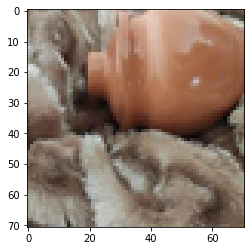

In [ ]:
img_path = '/content/drive/My Drive/8May/test/saucepan/IMG_20200505_102016.jpg'
from keras.preprocessing import image
import numpy as np
img = image.load_img(img_path, target_size=(71, 71))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
plt.imshow(img_tensor[0])
plt.show()

In [ ]:
from keras import backend as K
from tensorflow.keras import models

In [ ]:

conv_layer = model.get_layer("conv5_block32_concat")
heatmap_model = models.Model([model.inputs], [conv_layer.output, model.output])
preds = model.predict(img_tensor)

with tf.GradientTape() as gtape:
    conv_output, predictions = heatmap_model(img_tensor)
    loss = predictions[:, np.argmax(preds[0])]
    grads = gtape.gradient(loss, conv_output)
    pooled_grads = K.mean(grads, axis=(3, 1, 2))
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
heatmap = np.maximum(heatmap, 0)



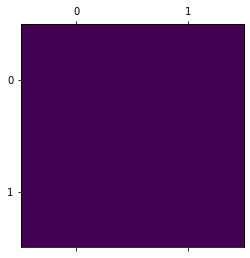

In [ ]:
max_heat = np.max(heatmap)
if max_heat == 0:
    max_heat = 1e-10
heatmap /= max_heat
heatmap = heatmap[0]
plt.matshow(heatmap)

In [ ]:
heatmap

array([[[0., 0.],
        [0., 0.]]], dtype=float32)

In [ ]:
arr = [ 0.104502, 0.099802, 0.107512, 0.109293, 0.101270]

In [ ]:
print( sum(arr)/len(arr) )

0.10447579999999998


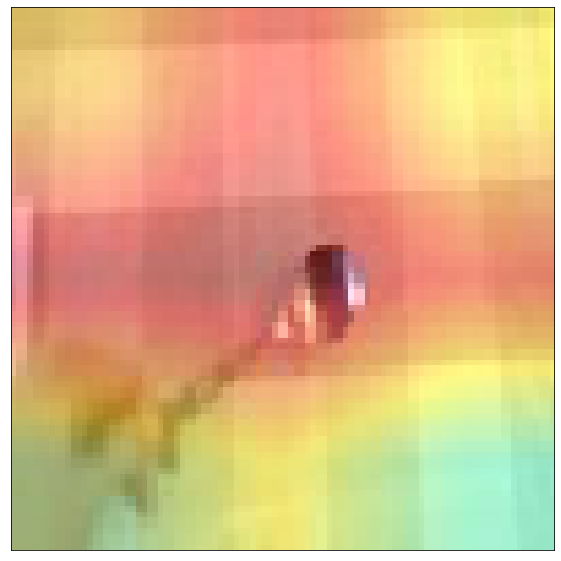

In [ ]:
import cv2
img = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('/content/drive/My Drive/16.05/cam.jpg', superimposed_img)

cam = '/content/drive/My Drive/16.05/cam.jpg'
cam = image.load_img(cam, target_size=(100, 100))

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(cam, cmap=plt.cm.binary)

In [ ]:
a = np.array([[[1,2,3],[2,2,3]],[[2,4,5],[1,3,6]],[[1,2,4],[2,3,4]],[[1,2,4],[1,2,6]]])

In [ ]:
a

array([[[1, 2, 3],
        [2, 2, 3]],

       [[2, 4, 5],
        [1, 3, 6]],

       [[1, 2, 4],
        [2, 3, 4]],

       [[1, 2, 4],
        [1, 2, 6]]])

In [ ]:
grads.shape

TensorShape([1, 17, 17, 64])

In [ ]:
a.mean(axis = (0))

array([[1.25, 2.5 , 4.  ],
       [1.5 , 2.5 , 4.75]])

In [ ]:
from psutil import *

In [ ]:
cpu_count()

2

In [ ]:
cpu_stats()

scpustats(ctx_switches=523333, interrupts=354049, soft_interrupts=244057, syscalls=0)

In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.000
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multihit
bogomips	: 4400.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits 